In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline


# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input, Concatenate, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils, to_categorical
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13418298632408929597
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1026893561879810368
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

    track_id       image_path       lp  train
0  s01_l01_1  s01_l01/1_1.png  7C24698      1
1  s01_l01_2  s01_l01/2_1.png  7C24698      1
2  s01_l01_2  s01_l01/2_2.png  7C24698      1
3  s01_l01_2  s01_l01/2_3.png  7C24698      1
4  s01_l01_2  s01_l01/2_4.png  7C24698      1
182336
1200
2400
3600
4800
6000
7200
8400
9600
10800
12000
13200
14400
15600
16800
18000
19200
20400
21600
22800
24000
25200
26400
27600
28800
30000
31200
32400
33600
34800
36000
37200
38400
39600
40800
42000
43200
44400
45600
46800
48000
49200
50400
51600
52800
54000
55200
56400
57600
58800
60000
61200
62400
63600
64800
66000
67200
68400
69600
70800
72000
73200
74400
75600
76800
78000
79200
80400
81600
82800
84000
85200
86400
87600
88800
90000
91200
92400
93600
94800
96000
97200
98400
99600
100800
102000
103200
104400
105600
106800
108000
109200
110400
111600
112800
114000
115200
116400
117600
118800
120000
121200
122400
123600
124800
126000
127200
128400
129600
130800
132000
133200
20000


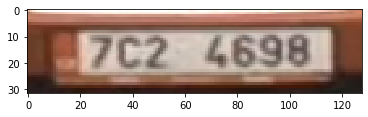

7C24698


'\nfor i in range(800):\n    #str(i).zfill(4)\n    #format(i, \'04d\')\n    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, \'04d\') + ".png")\n    print(img.shape)\n    #plt.imshow(img)\n    #plt.show()\n\nimg = cv2.imread("../../DIV2K_train_HR/0002.png")\nimg2 = img[0:1024, 0:1024,:]\nimg2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb\nplt.imshow(img2)\nplt.show()\n'

In [2]:
"""
    Reading Data from files
"""
import gc

data = pd.read_csv("../../image/trainVal.csv")
#print(data)
print(data.head())
#inputX = data[["Unnamed: 0", "w1 = 4"]].to_numpy() #需要為 np.array 的形式!

print(len(data))#182336

#train valid test
#total 105924
dataX = np.zeros((20000, 32, 128, 3), dtype=int)
dataY = []
count = 0

""" 
# not load test yet, due to not enough memory
finalTestX = np.zeros((76412, 32, 128, 3), dtype=int)
finalTestY = np.zeros((76412, 32, 128, 3), dtype=int)
testCount = 0
"""

#cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) → dst
i = 0
for j in range(len(data)):
    #img = cv2.imread("../../image/s01_l01/1_1.png")
    if data["train"][i] == 1:
        img = cv2.imread("../../image/" + data["image_path"][i])
        #print(img.shape)
        img = cv2.resize(img, (128, 32))
        dataX[count] = img
        
        dataY.append(data["lp"][i])
        
        count += 1
    """
    else:
        img = cv2.imread("../../image/" + data["image_path"][i])
        #print(img.shape)
        img = cv2.resize(img, (128, 32))
        finalTestY[testCount] = img
        img = cv2.resize(img, (64, 16))
        img = cv2.resize(img, (128, 32))
        finalTestX[testCount] = img
        testCount += 1
    """
    i+=5 
    if i % 1200 == 0:
        print(i)
        #gc.collect()
    if count == 20000:
        break;
    
print(count)
plt.imshow(dataX[5])
plt.show()
print(dataY[5])
    
    

"""
for i in range(800):
    #str(i).zfill(4)
    #format(i, '04d')
    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, '04d') + ".png")
    print(img.shape)
    #plt.imshow(img)
    #plt.show()

img = cv2.imread("../../DIV2K_train_HR/0002.png")
img2 = img[0:1024, 0:1024,:]
img2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb
plt.imshow(img2)
plt.show()
"""


In [3]:
"""
Peak Signal-to-Noise Ratio:
     > 40dB: great
    30~40dB: good
    20~30dB: bad
     < 20dB: worse
def psnr(tf_img1, tf_img2):
    return tf.image.psnr(tf_img1, tf_img2, max_val=255)
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def printHistory(history): 
    print(history.history.keys())
    """
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    """
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
# preprocessing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.3, random_state=41)

#del dataX, dataY
gc.collect()

"""
# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first': #Thean
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else: # TensorFlow
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1) #(batch, height, width, channels)
"""

# TensorFlow
X_train = X_train.reshape(-1, 32, 128, 3)
X_test = X_test.reshape(-1, 32, 128, 3) #(batch, timeSequence, feature)


# convert data type and normalize the values (8-bit = 256 = 0...255)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape)


(14000, 32, 128, 3)


In [5]:
# convert the class labels to 7*36-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, ) 
# 車牌長度為 8 26(A~Z) + 10(0~9) + 補 null
# 8 * (37)
# ord('A')


Y_train = []
Y_test = []

"""
for _str in y_train:
    temp_train = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_train += np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist()
        else:
            temp_train += np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist()
    for i in range(8 - len(_str)):
        temp_train += np_utils.to_categorical(36 , 37).tolist()
    Y_train.append(temp_train)
    
for _str in y_test:
    temp_test = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_test += np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist()
        else:
            temp_test += np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist()
    for i in range(8 - len(_str)):
        temp_test += np_utils.to_categorical(36 , 37).tolist()
    Y_test.append(temp_test)
"""

for _str in y_train:
    temp_train = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_train.append(np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist())
        else:
            temp_train.append(np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist())
    for i in range(8 - len(_str)):
        temp_train.append(np_utils.to_categorical(36 , 37).tolist())
    Y_train.append(temp_train)
    
for _str in y_test:
    temp_test = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_test.append(np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist())
        else:
            temp_test.append(np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist())
    for i in range(8 - len(_str)):
        temp_test.append(np_utils.to_categorical(36 , 37).tolist())
    Y_test.append(temp_test)


In [6]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
Y_train = np.transpose(Y_train ,(1, 0, 2))
Y_test = np.transpose(Y_test ,(1, 0, 2))
print(Y_train.shape)
print(y_train[0])
for element in Y_train:
    print(element[0])
#0 1 
#2 3
#4 5
#6 7

(8, 14000, 37)
7B47424
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [7]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
Y_train = Y_train.reshape(8, -1, 37)
Y_test = Y_test.reshape(8, -1, 37)
print(y_train[0])
for element in Y_train:
    print(element[0])
print(Y_train.shape)
print(Y_test.shape)
for elememt in y_train:
    if len(elememt) != 7:
        print(elememt)

7B47424
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(8, 14000, 37)
(8, 6000, 37)
DGR081AF
LXE091
WN727B
VY7906
MAN00001
HHLT2302
B48

In [14]:
#input (query, documents) output 0~3
#https://blog.csdn.net/churximi/article/details/61210129

def OCR():
    inputA = Input(shape=(32, 128, 3)) # 圖片大小
    
    x = Conv2D(64, (3, 3), activation='relu')(inputA)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)

    x = [Dense(37, activation='softmax', name='c%d'%(i+1))(x) for i in range(8)]
    
    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=inputA, outputs=x)
    return model


model = OCR()
print(model.summary())
#https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 30, 126, 64)  1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 28, 124, 64)  36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 14, 62, 64)   0           conv2d_32[0][0]             

In [43]:
print("[INFO] training model...")

#https://keras.io/zh/callbacks/
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
modelCheck = ModelCheckpoint('OCR{epoch:08d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = History()

model.fit(X_train,
          [element for element in Y_train], 
          batch_size=128,
          epochs=1000,
          validation_data=(X_test, [element for element in Y_test]),
          callbacks=[modelCheck, history])
    #,validation_data=([testAttrX, testImagesX], testY)

[INFO] training model...
Train on 14000 samples, validate on 6000 samples
Epoch 1/1000
14000/14000 [==============================] - 14s 1ms/step - loss: 16.7217 - c1_loss: 2.3969 - c2_loss: 1.4965 - c3_loss: 3.1441 - c4_loss: 2.3689 - c5_loss: 2.3738 - c6_loss: 2.4140 - c7_loss: 2.4340 - c8_loss: 0.0934 - c1_acc: 0.1637 - c2_acc: 0.6623 - c3_acc: 0.0789 - c4_acc: 0.1023 - c5_acc: 0.1018 - c6_acc: 0.1069 - c7_acc: 0.1058 - c8_acc: 0.9883 - val_loss: 16.2567 - val_c1_loss: 2.3442 - val_c2_loss: 1.3940 - val_c3_loss: 3.0795 - val_c4_loss: 2.3256 - val_c5_loss: 2.3364 - val_c6_loss: 2.3671 - val_c7_loss: 2.3843 - val_c8_loss: 0.0256 - val_c1_acc: 0.1603 - val_c2_acc: 0.6763 - val_c3_acc: 0.0647 - val_c4_acc: 0.0923 - val_c5_acc: 0.0933 - val_c6_acc: 0.1065 - val_c7_acc: 0.1170 - val_c8_acc: 0.9977
Epoch 2/1000
14000/14000 [==============================] - 10s 714us/step - loss: 16.2757 - c1_loss: 2.3384 - c2_loss: 1.4005 - c3_loss: 3.0873 - c4_loss: 2.3350 - c5_loss: 2.3301 - c6_loss: 2

14000/14000 [==============================] - 11s 767us/step - loss: 0.1243 - c1_loss: 0.0082 - c2_loss: 0.0233 - c3_loss: 0.0133 - c4_loss: 0.0206 - c5_loss: 0.0186 - c6_loss: 0.0187 - c7_loss: 0.0121 - c8_loss: 0.0095 - c1_acc: 0.9989 - c2_acc: 0.9973 - c3_acc: 0.9962 - c4_acc: 0.9980 - c5_acc: 0.9969 - c6_acc: 0.9964 - c7_acc: 0.9976 - c8_acc: 0.9994 - val_loss: 1.0195 - val_c1_loss: 0.1204 - val_c2_loss: 0.1483 - val_c3_loss: 0.1369 - val_c4_loss: 0.0791 - val_c5_loss: 0.1343 - val_c6_loss: 0.1913 - val_c7_loss: 0.1870 - val_c8_loss: 0.0221 - val_c1_acc: 0.9845 - val_c2_acc: 0.9802 - val_c3_acc: 0.9767 - val_c4_acc: 0.9888 - val_c5_acc: 0.9833 - val_c6_acc: 0.9772 - val_c7_acc: 0.9773 - val_c8_acc: 0.9983
Epoch 24/1000
14000/14000 [==============================] - 11s 771us/step - loss: 0.1272 - c1_loss: 0.0095 - c2_loss: 0.0239 - c3_loss: 0.0139 - c4_loss: 0.0211 - c5_loss: 0.0158 - c6_loss: 0.0183 - c7_loss: 0.0152 - c8_loss: 0.0094 - c1_acc: 0.9984 - c2_acc: 0.9968 - c3_acc: 0

14000/14000 [==============================] - 10s 732us/step - loss: 0.1061 - c1_loss: 0.0082 - c2_loss: 0.0191 - c3_loss: 0.0059 - c4_loss: 0.0201 - c5_loss: 0.0168 - c6_loss: 0.0156 - c7_loss: 0.0111 - c8_loss: 0.0092 - c1_acc: 0.9991 - c2_acc: 0.9981 - c3_acc: 0.9986 - c4_acc: 0.9981 - c5_acc: 0.9978 - c6_acc: 0.9981 - c7_acc: 0.9979 - c8_acc: 0.9994 - val_loss: 0.9417 - val_c1_loss: 0.1031 - val_c2_loss: 0.1085 - val_c3_loss: 0.1138 - val_c4_loss: 0.0862 - val_c5_loss: 0.1411 - val_c6_loss: 0.1929 - val_c7_loss: 0.1758 - val_c8_loss: 0.0203 - val_c1_acc: 0.9868 - val_c2_acc: 0.9855 - val_c3_acc: 0.9832 - val_c4_acc: 0.9883 - val_c5_acc: 0.9832 - val_c6_acc: 0.9802 - val_c7_acc: 0.9808 - val_c8_acc: 0.9985
Epoch 46/1000
14000/14000 [==============================] - 10s 749us/step - loss: 0.1024 - c1_loss: 0.0085 - c2_loss: 0.0191 - c3_loss: 0.0057 - c4_loss: 0.0190 - c5_loss: 0.0160 - c6_loss: 0.0143 - c7_loss: 0.0105 - c8_loss: 0.0092 - c1_acc: 0.9985 - c2_acc: 0.9981 - c3_acc: 0

14000/14000 [==============================] - 10s 728us/step - loss: 0.0878 - c1_loss: 0.0074 - c2_loss: 0.0175 - c3_loss: 0.0040 - c4_loss: 0.0191 - c5_loss: 0.0101 - c6_loss: 0.0118 - c7_loss: 0.0088 - c8_loss: 0.0092 - c1_acc: 0.9991 - c2_acc: 0.9986 - c3_acc: 0.9988 - c4_acc: 0.9984 - c5_acc: 0.9991 - c6_acc: 0.9981 - c7_acc: 0.9989 - c8_acc: 0.9994 - val_loss: 1.0141 - val_c1_loss: 0.1093 - val_c2_loss: 0.1233 - val_c3_loss: 0.1330 - val_c4_loss: 0.0883 - val_c5_loss: 0.1529 - val_c6_loss: 0.2092 - val_c7_loss: 0.1782 - val_c8_loss: 0.0200 - val_c1_acc: 0.9880 - val_c2_acc: 0.9863 - val_c3_acc: 0.9827 - val_c4_acc: 0.9888 - val_c5_acc: 0.9835 - val_c6_acc: 0.9787 - val_c7_acc: 0.9828 - val_c8_acc: 0.9985
Epoch 68/1000
14000/14000 [==============================] - 11s 752us/step - loss: 0.0974 - c1_loss: 0.0063 - c2_loss: 0.0185 - c3_loss: 0.0099 - c4_loss: 0.0188 - c5_loss: 0.0131 - c6_loss: 0.0135 - c7_loss: 0.0082 - c8_loss: 0.0092 - c1_acc: 0.9996 - c2_acc: 0.9985 - c3_acc: 0

14000/14000 [==============================] - 10s 718us/step - loss: 0.0877 - c1_loss: 0.0065 - c2_loss: 0.0175 - c3_loss: 0.0043 - c4_loss: 0.0195 - c5_loss: 0.0111 - c6_loss: 0.0113 - c7_loss: 0.0084 - c8_loss: 0.0092 - c1_acc: 0.9995 - c2_acc: 0.9986 - c3_acc: 0.9989 - c4_acc: 0.9983 - c5_acc: 0.9989 - c6_acc: 0.9986 - c7_acc: 0.9986 - c8_acc: 0.9994 - val_loss: 0.9164 - val_c1_loss: 0.1063 - val_c2_loss: 0.1120 - val_c3_loss: 0.1048 - val_c4_loss: 0.1008 - val_c5_loss: 0.1217 - val_c6_loss: 0.1907 - val_c7_loss: 0.1607 - val_c8_loss: 0.0194 - val_c1_acc: 0.9873 - val_c2_acc: 0.9863 - val_c3_acc: 0.9848 - val_c4_acc: 0.9867 - val_c5_acc: 0.9868 - val_c6_acc: 0.9797 - val_c7_acc: 0.9823 - val_c8_acc: 0.9987
Epoch 90/1000
14000/14000 [==============================] - 10s 712us/step - loss: 0.0863 - c1_loss: 0.0079 - c2_loss: 0.0167 - c3_loss: 0.0037 - c4_loss: 0.0184 - c5_loss: 0.0117 - c6_loss: 0.0113 - c7_loss: 0.0074 - c8_loss: 0.0092 - c1_acc: 0.9991 - c2_acc: 0.9989 - c3_acc: 0

14000/14000 [==============================] - 10s 725us/step - loss: 0.0686 - c1_loss: 0.0063 - c2_loss: 0.0140 - c3_loss: 0.0037 - c4_loss: 0.0155 - c5_loss: 0.0064 - c6_loss: 0.0068 - c7_loss: 0.0067 - c8_loss: 0.0092 - c1_acc: 0.9995 - c2_acc: 0.9991 - c3_acc: 0.9991 - c4_acc: 0.9988 - c5_acc: 0.9994 - c6_acc: 0.9987 - c7_acc: 0.9992 - c8_acc: 0.9994 - val_loss: 0.9388 - val_c1_loss: 0.1199 - val_c2_loss: 0.1108 - val_c3_loss: 0.1193 - val_c4_loss: 0.0823 - val_c5_loss: 0.1330 - val_c6_loss: 0.1806 - val_c7_loss: 0.1724 - val_c8_loss: 0.0204 - val_c1_acc: 0.9872 - val_c2_acc: 0.9868 - val_c3_acc: 0.9830 - val_c4_acc: 0.9897 - val_c5_acc: 0.9852 - val_c6_acc: 0.9802 - val_c7_acc: 0.9827 - val_c8_acc: 0.9987
Epoch 112/1000
14000/14000 [==============================] - 10s 717us/step - loss: 0.0715 - c1_loss: 0.0061 - c2_loss: 0.0160 - c3_loss: 0.0039 - c4_loss: 0.0166 - c5_loss: 0.0082 - c6_loss: 0.0055 - c7_loss: 0.0060 - c8_loss: 0.0092 - c1_acc: 0.9994 - c2_acc: 0.9986 - c3_acc: 

14000/14000 [==============================] - 10s 723us/step - loss: 0.0751 - c1_loss: 0.0076 - c2_loss: 0.0138 - c3_loss: 0.0036 - c4_loss: 0.0171 - c5_loss: 0.0102 - c6_loss: 0.0068 - c7_loss: 0.0068 - c8_loss: 0.0092 - c1_acc: 0.9991 - c2_acc: 0.9987 - c3_acc: 0.9994 - c4_acc: 0.9988 - c5_acc: 0.9983 - c6_acc: 0.9989 - c7_acc: 0.9989 - c8_acc: 0.9994 - val_loss: 0.9751 - val_c1_loss: 0.1257 - val_c2_loss: 0.1156 - val_c3_loss: 0.1079 - val_c4_loss: 0.0847 - val_c5_loss: 0.1496 - val_c6_loss: 0.1928 - val_c7_loss: 0.1793 - val_c8_loss: 0.0196 - val_c1_acc: 0.9870 - val_c2_acc: 0.9878 - val_c3_acc: 0.9857 - val_c4_acc: 0.9903 - val_c5_acc: 0.9853 - val_c6_acc: 0.9813 - val_c7_acc: 0.9830 - val_c8_acc: 0.9987
Epoch 134/1000
14000/14000 [==============================] - 10s 712us/step - loss: 0.0715 - c1_loss: 0.0069 - c2_loss: 0.0142 - c3_loss: 0.0049 - c4_loss: 0.0171 - c5_loss: 0.0073 - c6_loss: 0.0065 - c7_loss: 0.0054 - c8_loss: 0.0092 - c1_acc: 0.9992 - c2_acc: 0.9987 - c3_acc: 

14000/14000 [==============================] - 10s 712us/step - loss: 0.0773 - c1_loss: 0.0074 - c2_loss: 0.0150 - c3_loss: 0.0062 - c4_loss: 0.0157 - c5_loss: 0.0063 - c6_loss: 0.0096 - c7_loss: 0.0078 - c8_loss: 0.0092 - c1_acc: 0.9992 - c2_acc: 0.9987 - c3_acc: 0.9989 - c4_acc: 0.9989 - c5_acc: 0.9994 - c6_acc: 0.9983 - c7_acc: 0.9987 - c8_acc: 0.9994 - val_loss: 0.9607 - val_c1_loss: 0.1179 - val_c2_loss: 0.1110 - val_c3_loss: 0.1111 - val_c4_loss: 0.0885 - val_c5_loss: 0.1367 - val_c6_loss: 0.1892 - val_c7_loss: 0.1856 - val_c8_loss: 0.0207 - val_c1_acc: 0.9870 - val_c2_acc: 0.9870 - val_c3_acc: 0.9843 - val_c4_acc: 0.9893 - val_c5_acc: 0.9860 - val_c6_acc: 0.9823 - val_c7_acc: 0.9828 - val_c8_acc: 0.9985
Epoch 156/1000
14000/14000 [==============================] - 10s 710us/step - loss: 0.0682 - c1_loss: 0.0064 - c2_loss: 0.0147 - c3_loss: 0.0030 - c4_loss: 0.0157 - c5_loss: 0.0070 - c6_loss: 0.0060 - c7_loss: 0.0061 - c8_loss: 0.0092 - c1_acc: 0.9994 - c2_acc: 0.9988 - c3_acc: 

KeyboardInterrupt: 

== OCR accuracy ==
Train loss and accuracy
[0.9993571428571428, 0.999, 0.9999285714285714, 0.9988571428571429, 0.9993571428571428, 0.9991428571428571, 0.9995, 0.9994285714285714]
Train loss and accuracy
[0.9863333333333333, 0.9858333333333333, 0.9851666666666666, 0.9885, 0.9855, 0.9783333333333334, 0.9818333333333333, 0.9985]


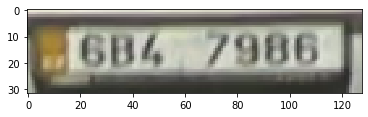

[[2.15543027e-22 1.00000000e+00 4.30648231e-22 ... 7.76208365e-24
  4.23967531e-26 1.17027646e-26]
 [4.96896320e-21 1.00000000e+00 5.67442128e-17 ... 1.07601647e-21
  1.06887494e-26 2.74405093e-27]
 [1.17854375e-08 6.21614547e-08 1.07576633e-13 ... 9.88252516e-14
  1.53268984e-16 9.46621390e-17]
 ...
 [2.88160979e-16 1.00000000e+00 1.07138300e-23 ... 4.11975027e-26
  7.81075834e-26 8.64465693e-28]
 [3.96731056e-14 1.00000000e+00 1.97614507e-16 ... 1.40859544e-17
  1.63082020e-21 6.88223812e-22]
 [1.39761776e-17 2.06061364e-14 3.22599749e-14 ... 3.34656859e-22
  1.05988196e-25 8.14011023e-26]]


In [17]:
model = OCR()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("OCR00000072.h5")
print("== OCR accuracy ==")
score = model.evaluate(X_train, [element for element in Y_train], verbose=0)
print('Train loss and accuracy')
print(score[9:])
score = model.evaluate(X_test, [element for element in Y_test], verbose=0)
print('Train loss and accuracy')
print(score[9:])

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

#printHistory(history)

== OCR accuracy ==
Train loss: 0.05777924941191084
Train accuracy: 0.0057597487913132
Test loss: 0.990486399862218
Test accuracy: 0.10919667894338742


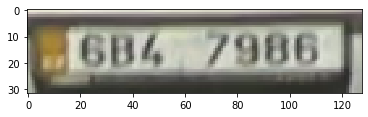

[[1.26553278e-29 1.00000000e+00 2.01656887e-29 ... 5.41051355e-28
  3.72906952e-29 2.86151180e-29]
 [2.50473617e-28 1.00000000e+00 8.29328083e-27 ... 4.05488757e-27
  2.02676396e-29 2.35848915e-29]
 [3.95542178e-16 9.45574907e-17 5.73668525e-26 ... 4.65302575e-22
  2.74508260e-23 6.98858692e-23]
 ...
 [1.83256086e-27 1.00000000e+00 1.21595985e-30 ... 3.39497580e-32
  1.85318396e-30 4.92170034e-31]
 [1.27270300e-21 1.00000000e+00 1.77226693e-27 ... 2.90634856e-24
  4.49641003e-25 4.37129028e-25]
 [1.71719242e-24 4.76393038e-23 6.41364426e-25 ... 7.24150333e-28
  2.76506364e-29 1.18016943e-28]]
dict_keys(['val_loss', 'val_c1_loss', 'val_c2_loss', 'val_c3_loss', 'val_c4_loss', 'val_c5_loss', 'val_c6_loss', 'val_c7_loss', 'val_c8_loss', 'val_c1_acc', 'val_c2_acc', 'val_c3_acc', 'val_c4_acc', 'val_c5_acc', 'val_c6_acc', 'val_c7_acc', 'val_c8_acc', 'loss', 'c1_loss', 'c2_loss', 'c3_loss', 'c4_loss', 'c5_loss', 'c6_loss', 'c7_loss', 'c8_loss', 'c1_acc', 'c2_acc', 'c3_acc', 'c4_acc', 'c5_acc',

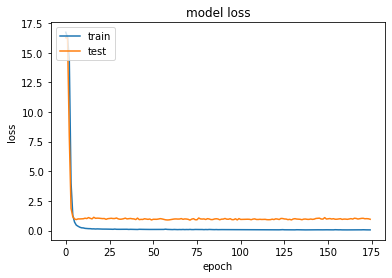

In [47]:
model = OCR()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("OCR00000072.h5")
print("== OCR accuracy ==")
score = model.evaluate(X_train, [element for element in Y_train], verbose=0)
print('Train loss and accuracy')
print(score)
score = model.evaluate(X_test, [element for element in Y_test], verbose=0)
print('Train loss and accuracy')
print(score)

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

printHistory(history)

print("== OCR accuracy ==")
score = model.evaluate(X_train, [element for element in Y_train], verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test, [element for element in Y_test], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

printHistory(history)

In [9]:
#input (query, documents) output 0~3
#https://blog.csdn.net/churximi/article/details/61210129

from keras.layers import Reshape
K = keras_backend
def Mix():
    inputA = Input(shape=(32, 128, 3)) # 圖片大小
    
    x = Conv2D(64, (3, 3), padding='same')(inputA) #30 126 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x) #28 124 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x) #14 62 64
    
    x = Conv2D(128, (3, 3), padding='same')(x) #12 60 128
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Reshape((-1, 256))(x)
    x = Dense(64, activation='relu')(x)
    
    x = LSTM(256)(x)
    x = [Dense(37, activation='softmax', name='c%d'%(i+1))(x) for i in range(8)]
    
    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=inputA, outputs=x)
    return model


model = Mix()
print(model.summary())
#https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 128, 64)  256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 128, 64)  0           batch_normalization_1[0][0]      
_____________________________________

In [50]:
print("[INFO] training model...")

#https://keras.io/zh/callbacks/
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
modelCheck = ModelCheckpoint('Mix{epoch:08d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=50)
history = History()

model.fit(X_train,
          [element for element in Y_train], 
          batch_size=128,
          epochs=100,
          validation_data=(X_test, [element for element in Y_test]),
          callbacks=[modelCheck, earlyStop, history])
    #,validation_data=([testAttrX, testImagesX], testY)

[INFO] training model...
Train on 14000 samples, validate on 6000 samples
Epoch 1/100
14000/14000 [==============================] - 90s 6ms/step - loss: 16.9124 - c1_loss: 2.4395 - c2_loss: 1.4986 - c3_loss: 3.1289 - c4_loss: 2.4074 - c5_loss: 2.4081 - c6_loss: 2.4569 - c7_loss: 2.4758 - c8_loss: 0.0971 - c1_acc: 0.1559 - c2_acc: 0.6646 - c3_acc: 0.0759 - c4_acc: 0.1009 - c5_acc: 0.1029 - c6_acc: 0.1048 - c7_acc: 0.1019 - c8_acc: 0.9884 - val_loss: 16.2680 - val_c1_loss: 2.3546 - val_c2_loss: 1.3925 - val_c3_loss: 3.0707 - val_c4_loss: 2.3279 - val_c5_loss: 2.3326 - val_c6_loss: 2.3823 - val_c7_loss: 2.3834 - val_c8_loss: 0.0239 - val_c1_acc: 0.1603 - val_c2_acc: 0.6763 - val_c3_acc: 0.0823 - val_c4_acc: 0.0952 - val_c5_acc: 0.1098 - val_c6_acc: 0.0975 - val_c7_acc: 0.1143 - val_c8_acc: 0.9977
Epoch 2/100
14000/14000 [==============================] - 82s 6ms/step - loss: 16.2324 - c1_loss: 2.3334 - c2_loss: 1.3906 - c3_loss: 3.0768 - c4_loss: 2.3307 - c5_loss: 2.3319 - c6_loss: 2.367

14000/14000 [==============================] - 85s 6ms/step - loss: 0.0470 - c1_loss: 0.0063 - c2_loss: 0.0071 - c3_loss: 0.0119 - c4_loss: 0.0053 - c5_loss: 0.0052 - c6_loss: 0.0054 - c7_loss: 0.0055 - c8_loss: 3.2003e-04 - c1_acc: 0.9999 - c2_acc: 0.9999 - c3_acc: 0.9999 - c4_acc: 1.0000 - c5_acc: 1.0000 - c6_acc: 1.0000 - c7_acc: 1.0000 - c8_acc: 1.0000 - val_loss: 0.4029 - val_c1_loss: 0.0566 - val_c2_loss: 0.0567 - val_c3_loss: 0.0786 - val_c4_loss: 0.0395 - val_c5_loss: 0.0405 - val_c6_loss: 0.0549 - val_c7_loss: 0.0675 - val_c8_loss: 0.0088 - val_c1_acc: 0.9888 - val_c2_acc: 0.9873 - val_c3_acc: 0.9847 - val_c4_acc: 0.9923 - val_c5_acc: 0.9915 - val_c6_acc: 0.9883 - val_c7_acc: 0.9852 - val_c8_acc: 0.9988
Epoch 24/100
14000/14000 [==============================] - 85s 6ms/step - loss: 0.0395 - c1_loss: 0.0053 - c2_loss: 0.0058 - c3_loss: 0.0099 - c4_loss: 0.0045 - c5_loss: 0.0045 - c6_loss: 0.0047 - c7_loss: 0.0045 - c8_loss: 2.6574e-04 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc

14000/14000 [==============================] - 89s 6ms/step - loss: 0.0058 - c1_loss: 7.7872e-04 - c2_loss: 7.7865e-04 - c3_loss: 0.0013 - c4_loss: 7.3249e-04 - c5_loss: 7.1039e-04 - c6_loss: 7.1960e-04 - c7_loss: 6.8610e-04 - c8_loss: 4.3705e-05 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - c6_acc: 1.0000 - c7_acc: 1.0000 - c8_acc: 1.0000 - val_loss: 0.3705 - val_c1_loss: 0.0519 - val_c2_loss: 0.0484 - val_c3_loss: 0.0646 - val_c4_loss: 0.0379 - val_c5_loss: 0.0378 - val_c6_loss: 0.0528 - val_c7_loss: 0.0679 - val_c8_loss: 0.0091 - val_c1_acc: 0.9908 - val_c2_acc: 0.9888 - val_c3_acc: 0.9860 - val_c4_acc: 0.9932 - val_c5_acc: 0.9932 - val_c6_acc: 0.9893 - val_c7_acc: 0.9853 - val_c8_acc: 0.9988
Epoch 46/100
14000/14000 [==============================] - 91s 6ms/step - loss: 0.0055 - c1_loss: 7.3693e-04 - c2_loss: 7.4714e-04 - c3_loss: 0.0012 - c4_loss: 6.8800e-04 - c5_loss: 6.7416e-04 - c6_loss: 6.8753e-04 - c7_loss: 6.4614e-04 - c8_loss: 4.022

Epoch 67/100
14000/14000 [==============================] - 91s 7ms/step - loss: 0.0035 - c1_loss: 4.6602e-04 - c2_loss: 4.7727e-04 - c3_loss: 8.8663e-04 - c4_loss: 3.9518e-04 - c5_loss: 3.9119e-04 - c6_loss: 4.0488e-04 - c7_loss: 4.3017e-04 - c8_loss: 1.8832e-05 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - c6_acc: 1.0000 - c7_acc: 1.0000 - c8_acc: 1.0000 - val_loss: 0.3644 - val_c1_loss: 0.0506 - val_c2_loss: 0.0470 - val_c3_loss: 0.0595 - val_c4_loss: 0.0371 - val_c5_loss: 0.0390 - val_c6_loss: 0.0565 - val_c7_loss: 0.0659 - val_c8_loss: 0.0089 - val_c1_acc: 0.9920 - val_c2_acc: 0.9912 - val_c3_acc: 0.9875 - val_c4_acc: 0.9938 - val_c5_acc: 0.9928 - val_c6_acc: 0.9887 - val_c7_acc: 0.9875 - val_c8_acc: 0.9988
Epoch 68/100
14000/14000 [==============================] - 89s 6ms/step - loss: 0.0032 - c1_loss: 4.3559e-04 - c2_loss: 4.4731e-04 - c3_loss: 8.2849e-04 - c4_loss: 3.6860e-04 - c5_loss: 3.6710e-04 - c6_loss: 3.7846e-04 - c7_loss: 4.0325

Epoch 78/100
14000/14000 [==============================] - 88s 6ms/step - loss: 0.0018 - c1_loss: 2.4255e-04 - c2_loss: 2.4302e-04 - c3_loss: 4.4118e-04 - c4_loss: 2.0786e-04 - c5_loss: 2.0448e-04 - c6_loss: 2.1054e-04 - c7_loss: 2.2222e-04 - c8_loss: 1.0152e-05 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - c6_acc: 1.0000 - c7_acc: 1.0000 - c8_acc: 1.0000 - val_loss: 0.3760 - val_c1_loss: 0.0524 - val_c2_loss: 0.0481 - val_c3_loss: 0.0596 - val_c4_loss: 0.0381 - val_c5_loss: 0.0405 - val_c6_loss: 0.0585 - val_c7_loss: 0.0697 - val_c8_loss: 0.0090 - val_c1_acc: 0.9920 - val_c2_acc: 0.9910 - val_c3_acc: 0.9873 - val_c4_acc: 0.9938 - val_c5_acc: 0.9928 - val_c6_acc: 0.9890 - val_c7_acc: 0.9867 - val_c8_acc: 0.9988
Epoch 79/100
14000/14000 [==============================] - 90s 6ms/step - loss: 0.0017 - c1_loss: 2.2780e-04 - c2_loss: 2.2903e-04 - c3_loss: 4.1751e-04 - c4_loss: 1.9475e-04 - c5_loss: 1.9478e-04 - c6_loss: 1.9882e-04 - c7_loss: 2.0953

Epoch 89/100
14000/14000 [==============================] - 95s 7ms/step - loss: 9.6049e-04 - c1_loss: 1.3254e-04 - c2_loss: 1.3064e-04 - c3_loss: 2.3110e-04 - c4_loss: 1.1241e-04 - c5_loss: 1.1329e-04 - c6_loss: 1.1416e-04 - c7_loss: 1.2072e-04 - c8_loss: 5.6169e-06 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - c6_acc: 1.0000 - c7_acc: 1.0000 - c8_acc: 1.0000 - val_loss: 0.3869 - val_c1_loss: 0.0544 - val_c2_loss: 0.0491 - val_c3_loss: 0.0596 - val_c4_loss: 0.0391 - val_c5_loss: 0.0425 - val_c6_loss: 0.0606 - val_c7_loss: 0.0726 - val_c8_loss: 0.0091 - val_c1_acc: 0.9922 - val_c2_acc: 0.9915 - val_c3_acc: 0.9872 - val_c4_acc: 0.9942 - val_c5_acc: 0.9932 - val_c6_acc: 0.9892 - val_c7_acc: 0.9863 - val_c8_acc: 0.9988
Epoch 90/100
14000/14000 [==============================] - 94s 7ms/step - loss: 9.0970e-04 - c1_loss: 1.2501e-04 - c2_loss: 1.2233e-04 - c3_loss: 2.2097e-04 - c4_loss: 1.0699e-04 - c5_loss: 1.0698e-04 - c6_loss: 1.0774e-04 - c7_loss

Epoch 100/100
14000/14000 [==============================] - 88s 6ms/step - loss: 5.2775e-04 - c1_loss: 7.3002e-05 - c2_loss: 7.0731e-05 - c3_loss: 1.2568e-04 - c4_loss: 6.2655e-05 - c5_loss: 6.3021e-05 - c6_loss: 6.3030e-05 - c7_loss: 6.6504e-05 - c8_loss: 3.1308e-06 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - c6_acc: 1.0000 - c7_acc: 1.0000 - c8_acc: 1.0000 - val_loss: 0.3986 - val_c1_loss: 0.0564 - val_c2_loss: 0.0503 - val_c3_loss: 0.0609 - val_c4_loss: 0.0404 - val_c5_loss: 0.0440 - val_c6_loss: 0.0627 - val_c7_loss: 0.0746 - val_c8_loss: 0.0093 - val_c1_acc: 0.9920 - val_c2_acc: 0.9918 - val_c3_acc: 0.9883 - val_c4_acc: 0.9942 - val_c5_acc: 0.9930 - val_c6_acc: 0.9892 - val_c7_acc: 0.9867 - val_c8_acc: 0.9988


== Mix accuracy ==
Train loss and accuracy
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Train loss and accuracy
[0.992, 0.9911666666666666, 0.987, 0.9938333333333333, 0.9926666666666667, 0.9888333333333333, 0.9866666666666667, 0.9988333333333334]


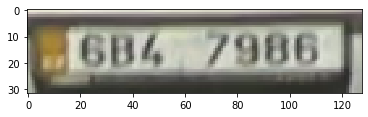

[[3.34993899e-08 9.99982834e-01 3.82809367e-06 ... 1.13782726e-10
  1.28585997e-09 2.44167797e-10]
 [6.63686478e-06 9.99934912e-01 9.05674938e-07 ... 8.49079917e-10
  8.21573654e-09 2.86189933e-10]
 [3.88964632e-04 1.22309366e-05 6.55625217e-06 ... 1.10577203e-09
  5.56903856e-08 3.16461879e-09]
 ...
 [1.09277435e-05 9.99980927e-01 9.32933375e-08 ... 7.85639642e-09
  5.88318150e-09 5.02580244e-09]
 [3.87176726e-08 9.99976397e-01 8.48552162e-09 ... 3.96145028e-09
  6.76711931e-09 6.33692376e-10]
 [6.95995463e-04 4.62185126e-05 1.00797740e-06 ... 1.77116704e-08
  1.92302139e-07 1.77939626e-07]]


In [18]:
model = Mix()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("Mix00000055.h5")
print("== Mix accuracy ==")
score = model.evaluate(X_train, [element for element in Y_train], verbose=0)
print('Train loss and accuracy')
print(score[9:])
score = model.evaluate(X_test, [element for element in Y_test], verbose=0)
print('Train loss and accuracy')
print(score[9:])

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

#printHistory(history)

== Mix accuracy ==
Train loss: 0.0005019175172450819
Train accuracy: 7.009051896082902e-05
Test loss: 0.3986119177285582
Test accuracy: 0.0564301391566017


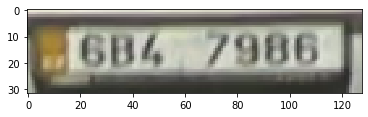

[[6.14472118e-09 9.99998569e-01 5.11676944e-07 ... 8.32731627e-12
  1.14869135e-10 3.58626635e-11]
 [4.62393501e-07 9.99995828e-01 2.08175788e-08 ... 4.89370384e-11
  5.56324209e-10 2.14613743e-11]
 [1.28080019e-05 4.09797366e-07 2.05368295e-07 ... 6.31896896e-11
  3.01107295e-09 2.00763559e-10]
 ...
 [8.36150889e-07 9.99998569e-01 1.35600153e-09 ... 3.36467160e-10
  2.54739480e-10 2.13918064e-10]
 [1.52328266e-08 9.99992251e-01 1.74114181e-10 ... 4.34415226e-10
  5.80973714e-10 1.62881791e-10]
 [9.84270719e-06 1.96288426e-07 7.87626320e-09 ... 1.19028093e-10
  2.48031973e-09 5.43522516e-09]]
dict_keys(['val_loss', 'val_c1_loss', 'val_c2_loss', 'val_c3_loss', 'val_c4_loss', 'val_c5_loss', 'val_c6_loss', 'val_c7_loss', 'val_c8_loss', 'val_c1_acc', 'val_c2_acc', 'val_c3_acc', 'val_c4_acc', 'val_c5_acc', 'val_c6_acc', 'val_c7_acc', 'val_c8_acc', 'loss', 'c1_loss', 'c2_loss', 'c3_loss', 'c4_loss', 'c5_loss', 'c6_loss', 'c7_loss', 'c8_loss', 'c1_acc', 'c2_acc', 'c3_acc', 'c4_acc', 'c5_acc',

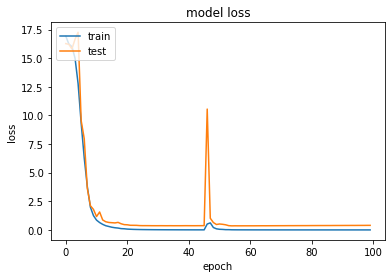

In [51]:
print("== Mix accuracy ==")
score = model.evaluate(X_train, [element for element in Y_train], verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test, [element for element in Y_test], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

printHistory(history)